In [1]:
!pip install pyLDAvis
!python -m spacy download de_core_news_sm
import os
import sys

!git clone https://github.com/YStrehlow/nlp-ws19.git

sys.path.insert(0, "/nlp-ws19/")
os.chdir('/nlp-ws19')

[+] Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\en_core_web_sm
-->
C:\Users\ystrehlow\AppData\Roaming\Python\Python36\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


Ihre Berechtigungen reichen nicht aus, um diesen Vorgang auszuf�hren.


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import spacy

import itertools

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

from plot_cm import plot_confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Dataset

#### Read the .csv file into the variable "data"

In [3]:
data = pd.read_csv("articles.csv")

#### Print the first 10 rows

In [4]:
data[:10]

,id,char_count,content,title,url,category,content_preprocessed
0,337240,4894,'Wieder einmal will die Türkei Abgeordnete nic...,"'Erneuter Incirlik-Eklat Pokern um den ""Tornad...",'http://www.spiegel.de//politik/deutschland/in...,politik,'Türkei Abgeordnete Incirlik lassen. Bundesreg...
1,337259,469,'Stuttgart (dpa/lsw) - Ministerpräsident Winfr...,'Kretschmann empfängt Adelsfamilien zum gemein...,'http://www.sueddeutsche.de/news/politik/regie...,politik,'Stuttgart (dpa/lsw) - Ministerpräsident Winfr...
2,337262,372,'Cottbus (dpa/bb) - Der Braunkohlenausschuss d...,'Braunkohlenausschuss kommt nach Revierkonzept...,'http://www.sueddeutsche.de/news/wirtschaft/en...,wirtschaft,'Cottbus (dpa/bb) - Braunkohlenausschuss Land ...
3,337267,3404,'Frank Plasberg lässt die Erfolgsaussichten de...,"'""Hart aber fair"" mit Frank Plasberg Es muss n...",'http://www.sueddeutsche.de/medien/hart-aber-f...,medien,'Frank Plasberg lässt Erfolgsaussichten SPD-Ka...
4,337271,492,'Washington (dpa) - US-Präsident Donald Trump ...,'McMaster: Bericht über Trumps Geheimnis-Weite...,'http://www.sueddeutsche.de/news/politik/gehei...,politik,'Washington (dpa) - US-Präsident Donald Trump ...
5,337278,502,'New York (dpa) - UN-Generalsekretär António G...,'Vereinte Nationen verurteilen Nordkoreas Rake...,'http://www.sueddeutsche.de/news/politik/konfl...,politik,'New York (dpa) - UN-Generalsekretär António G...
6,337284,2638,'Düsseldorf – Die SPD will nach ihrer schweren...,'Nach NRW-Schlappe | SPD schließt große&lt;br ...,'http://www.bild.de/politik/inland/politik/nrw...,politik,'Düsseldorf – SPD schwer Niederlage Landtagswa...
7,337294,2317,'Nordkorea könnte Experten zufolge hinter der ...,'Experten: Nordkorea könnte hinter weltweiter ...,'http://www.donaukurier.de/nachrichten/wirtsch...,wirtschaft,'Nordkorea Experte zufolge jung weltweit Cyber...
8,337297,153,'Der Bundesgerichtshof (BGH) hat der Unterlass...,'BGH-Urteil - Darlehenskontogebühren bei Bausp...,'http://www.donaukurier.de/nachrichten/wirtsch...,wirtschaft,'Bundesgerichtshof (BGH) Unterlassungsklage Ve...
9,337298,2317,'Nordkorea könnte Experten zufolge hinter der ...,'Experten: Nordkorea könnte hinter weltweiter ...,'http://www.donaukurier.de/nachrichten/medien/...,medien,'Nordkorea Experte zufolge jung weltweit Cyber...


#### Investigate how many instances of each class are present in the data 

In [5]:
data['category'].value_counts()

sport         6366
politik       5110
wirtschaft    3341
kultur        1366
leben         1264
medien        1103
Name: category, dtype: int64

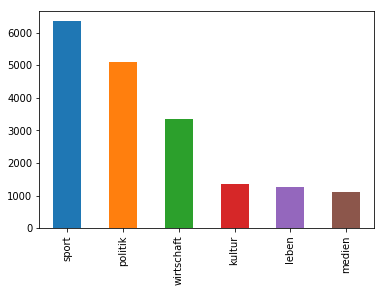

In [6]:
data['category'].value_counts().plot(kind='bar')

In [7]:
data.head()

,id,char_count,content,title,url,category,content_preprocessed
0,337240,4894,'Wieder einmal will die Türkei Abgeordnete nic...,"'Erneuter Incirlik-Eklat Pokern um den ""Tornad...",'http://www.spiegel.de//politik/deutschland/in...,politik,'Türkei Abgeordnete Incirlik lassen. Bundesreg...
1,337259,469,'Stuttgart (dpa/lsw) - Ministerpräsident Winfr...,'Kretschmann empfängt Adelsfamilien zum gemein...,'http://www.sueddeutsche.de/news/politik/regie...,politik,'Stuttgart (dpa/lsw) - Ministerpräsident Winfr...
2,337262,372,'Cottbus (dpa/bb) - Der Braunkohlenausschuss d...,'Braunkohlenausschuss kommt nach Revierkonzept...,'http://www.sueddeutsche.de/news/wirtschaft/en...,wirtschaft,'Cottbus (dpa/bb) - Braunkohlenausschuss Land ...
3,337267,3404,'Frank Plasberg lässt die Erfolgsaussichten de...,"'""Hart aber fair"" mit Frank Plasberg Es muss n...",'http://www.sueddeutsche.de/medien/hart-aber-f...,medien,'Frank Plasberg lässt Erfolgsaussichten SPD-Ka...
4,337271,492,'Washington (dpa) - US-Präsident Donald Trump ...,'McMaster: Bericht über Trumps Geheimnis-Weite...,'http://www.sueddeutsche.de/news/politik/gehei...,politik,'Washington (dpa) - US-Präsident Donald Trump ...


## Classification Time

#### Load the german spacy word model

In [6]:
nlp = spacy.load("de_core_news_sm")

#### Apply spacy pre-processing to content

In [54]:
content = nlp.pipe(data['content'])

#### Read the stopwords file "stopwords.txt" line by line

In [21]:
with open('stopwords.txt', 'r') as f:
    stopwords = f.readlines()

In [ ]:
stopwords[:10]

#### Remove whitespaces and newlines from the stopwords

In [23]:
stopwords = [x.strip() for x in stopwords]

In [11]:
def set_stop_word(sw):
    if sw.startswith("#") or sw.startswith("//"):
        return
    nlp.vocab[sw].is_stop = True
    sw = sw[0].upper() + sw[1:]
    nlp.vocab[sw].is_stop = True
    
for w in stopwords:
    set_stop_word(w)

#### Remove stopwords from content

In [40]:
#this line takes really long to execute. Stopwords are removed and lemmas are extracted.
#the result from this line is already stored in data['content_preprocessed'] -> see next line

#content_without_stopwords=[]
#for t in content:
#    content_without_stopwords.append("".join(list("".join(tok.lemma_ + tok.whitespace_) for tok in t if not tok.is_stop)))

In [37]:
content_without_stopwords = data['content_preprocessed']

In [43]:
content_without_stopwords[3]

'\'Frank Plasberg lässt Erfolgsaussichten SPD-Kanzlerkandidaten diskutieren. Tipps Schulz schauspielern Ulrich Matthes - CSU-Politiker Söder kontern Angst-Rhetorik. Martin Schulz Pappkamerad. jedenfalls fast ausschließlich sehen Frank Plasbergs Hart fair-Runde Montagabend. Einspieler zeigen Reichstag Berlin, Martin-Schulz-Pappaufsteller Satz sagen SPD-Niederlage Nordrhein-Westfalen. Gast Studio lugen ständig Büstenfoto Martin Schulz hervor. egal, sprechen: Schulz schauen unscharf schultern. Mann, sprechen , , versuchen Sendung überspielen. inszenieren regelrecht Abwesenheit SPD-Kanzlerkandidaten, wochenlang wahnsinnig präsent , Umfragewerte Partei Höhe schießen. 17 000 bürgern SPD eintreten. Union Angst bekommen, Merkel Seehofer zusammenraufen. NRW-Wahl (Schleswig-Holstein Saarland) . Nicht-da-Sein Martin Schulz , abwesend Martin Schulz Hart fair vorwerfen . SPD-Fraktionsvorsitzenden Thoma Oppermann, , Fehler , Schulz Landtagswahlkampf heraushalten. Tagesspiegel-Kolumnist Hajo Schumach

#### Split the data into two sets: one for training the classifier and the other one for testing the performance

In [38]:
split = int((len(data)/100)*80)

train = data[:split]
test = data[split:].reset_index(drop=True)

#### Encode the texts with the TfidfVectorizer

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000, min_df=2)
train_x = tfidf_vectorizer.fit_transform(train['content_preprocessed']).toarray()
test_x = tfidf_vectorizer.transform(test['content_preprocessed']).toarray()

In [42]:
tfidf_vectorizer.vocabulary_

{'türkei': 867,
 'abgeordnete': 63,
 'incirlik': 442,
 'lassen': 522,
 'bundesregierung': 187,
 'hoffen': 431,
 'scheinen': 733,
 'bundeswehr': 190,
 'bereiten': 140,
 'besuchen': 153,
 'türkisch': 868,
 'genau': 371,
 'planen': 659,
 'dienstag': 225,
 '12': 6,
 'stefan': 805,
 'führen': 354,
 'bild': 163,
 'gespräch': 383,
 '15': 9,
 '45': 51,
 'berlin': 143,
 'bringen': 178,
 'deutsch': 219,
 'soldat': 776,
 'erneut': 284,
 'schwer': 749,
 'beziehung': 161,
 'trotz': 856,
 'zahlreiche': 972,
 'außenminister': 119,
 'gabriel': 357,
 'sonntag': 779,
 'reisen': 702,
 'politiker': 666,
 'zusammenarbeit': 984,
 'herbst': 418,
 '2016': 24,
 'deutschland': 222,
 'streiten': 812,
 'einigen': 248,
 'umstritten': 869,
 'bundestag': 188,
 'schlagen': 735,
 'scharf': 731,
 'drohen': 237,
 'amt': 81,
 'bundeskanzlerin': 185,
 'angela': 88,
 'merkel': 579,
 'kommen': 492,
 'zeigen': 973,
 'regierung': 699,
 'präsident': 683,
 'erdogan': 269,
 'april': 101,
 'mitte': 588,
 'letzt': 535,
 'woche': 9

In [16]:
train_x[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03696839, 0.        , 0.        , 0.02948319,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04308707, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02966504,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03916682, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03984024, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0454919 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04820

#### Encode the labels with the LabelEncoder

In [49]:
le = LabelEncoder()
train_y = le.fit_transform(train['category'])
test_y = le.transform(test['category'])

#### Random Forest Classifier (RandomForestClassifier)

In [50]:
clf = RandomForestClassifier(10, random_state=2)
clf.fit(train_x, train_y)

predictions = clf.predict(test_x)
cnf_matrix = confusion_matrix(test_y, predictions)

0.7517520215633423


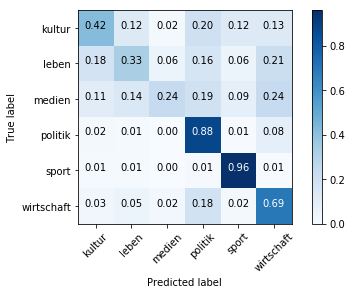

In [52]:
print(accuracy_score(predictions, test_y))
plot_confusion_matrix(cnf_matrix, classes=le.classes_, title='', normalize=True)

In [53]:
lda_texts = []
for text in data['content_preprocessed'][:1000]:
    lda_texts.append([tok.text for tok in nlp(text) if tok.is_alpha])

In [54]:
common_dictionary = Dictionary(lda_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in lda_texts]

lda = LdaModel(common_corpus, num_topics=10)

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

In [18]:
vis = pyLDAvis.gensim.prepare(lda, common_corpus, dictionary=common_dictionary)
vis

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.008228 -0.005455       1        1  14.655490
7      0.027025  0.006170       2        1  13.973178
6      0.014945 -0.020583       3        1  12.748040
0      0.018565  0.055198       4        1  11.666671
8     -0.013680 -0.037532       5        1  11.093026
5     -0.019558 -0.009579       6        1  10.077782
4      0.043342 -0.010201       7        1   8.801963
3     -0.020578 -0.009962       8        1   6.729275
2     -0.057205  0.022595       9        1   5.268434
9     -0.001083  0.009350      10        1   4.986149, topic_info=      Category        Freq             Term       Total  loglift  logprob
6010   Default  306.000000               FC  306.000000  30.0000  30.0000
342    Default  207.000000            Bayer  207.000000  29.0000  29.0000
145    Default  114.000000           Türkei  114.000000  28.0000  28.0000
2753   Default  154.000000          München  154.000000  27.0000  27.0000
609    Default  523.000000          Prozent  523.000000  26.0000  26.0000
12082  Default   81.000000          Kimmich   81.000000  25.0000  25.0000
519    Default  314.000000            Trump  314.000000  24.0000  24.0000
387    Default  140.000000              SPD  140.000000  23.0000  23.0000
573    Default  112.000000              CDU  112.000000  22.0000  22.0000
703    Default  520.000000             Euro  520.000000  21.0000  21.0000
2302   Default  348.000000          Million  348.000000  20.0000  20.0000
264    Default   59.000000         türkisch   59.000000  19.0000  19.0000
58     Default   46.000000          Erdogan   46.000000  18.0000  18.0000
128    Default   62.000000           Soldat   62.000000  17.0000  17.0000
16     Default   40.000000           Ankara   40.000000  16.0000  16.0000
1665   Default  153.000000            meist  153.000000  15.0000  15.0000
584    Default   82.000000              FDP   82.000000  14.0000  14.0000
2138   Default  242.000000              SPÖ  242.000000  13.0000  13.0000
1421   Default  187.000000              USA  187.000000  12.0000  12.0000
12077  Default   50.000000           Joshua   50.000000  11.0000  11.0000
4122   Default  236.000000           kernen  236.000000  10.0000  10.0000
9460   Default   21.000000          Benfica   21.000000   9.0000   9.0000
116    Default  162.000000        Präsident  162.000000   8.0000   8.0000
155    Default  142.000000       Washington  142.000000   7.0000   7.0000
6669   Default   45.000000            Nizza   45.000000   6.0000   6.0000
1955   Default  111.000000          Zeitung  111.000000   5.0000   5.0000
526    Default  235.000000              dpa  235.000000   4.0000   4.0000
6979   Default   51.000000              Rom   51.000000   3.0000   3.0000
42     Default   70.000000  Bundesregierung   70.000000   2.0000   2.0000
5021   Default   41.000000             Ford   41.000000   1.0000   1.0000
...        ...         ...              ...         ...      ...      ...
6665   Topic10    7.612583            Favre   50.209572   1.1121  -6.8248
1421   Topic10   15.432425              USA  187.444351   0.5015  -6.1181
1826   Topic10    9.095396            malen   79.324524   0.8327  -6.6468
703    Topic10   23.408464             Euro  520.817078  -0.1038  -5.7015
274    Topic10   12.929006           zeigen  184.173935   0.3421  -6.2951
2188   Topic10   11.809525              ÖVP  153.547424   0.4334  -6.3856
433    Topic10   15.413974            geben  276.768402   0.1106  -6.1193
68     Topic10   11.344745         Gespräch  150.337677   0.4144  -6.4258
671    Topic10    9.876617            wolle  117.039085   0.5262  -6.5644
9676   Topic10    4.664627            Kasse   23.363710   1.3873  -7.3145
609    Topic10   18.855118          Prozent  523.247742  -0.3248  -5.9178
623    Topic10   10.056414    Verantwortung  136.785660   0.3883  -6.5463
503    Topic10    8.715171           Donald   98.6610

In [7]:
politic_texts = []
for i, text in enumerate(data['content_preprocessed']):
    if i >= 1000:
        break
    if data['category'][i] == 'politik':
        politic_texts.append([tok.text for tok in nlp(text) if tok.is_alpha])

In [8]:
politic_dictionary = Dictionary(politic_texts)
politic_corpus = [politic_dictionary.doc2bow(text) for text in politic_texts]

politic_lda = LdaModel(politic_corpus, num_topics=5)

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(ge

In [9]:
politic_vis = pyLDAvis.gensim.prepare(politic_lda, politic_corpus, dictionary=politic_dictionary)
politic_vis

C:\Users\ystrehlow\AppData\Local\Continuum\anaconda3\envs\n3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.031744 -0.004223       1        1  28.078091
2     -0.008422  0.005670       2        1  23.138962
4      0.034775 -0.010400       3        1  21.349077
1      0.007531  0.030450       4        1  17.085457
3     -0.002140 -0.021497       5        1  10.348416, topic_info=     Category        Freq             Term       Total  loglift  logprob
145   Default  109.000000           Türkei  109.000000  30.0000  30.0000
1146  Default  225.000000              SPÖ  225.000000  29.0000  29.0000
264   Default   58.000000         türkisch   58.000000  28.0000  28.0000
16    Default   41.000000           Ankara   41.000000  27.0000  27.0000
2044  Default  177.000000      Vizekanzler  177.000000  26.0000  26.0000
42    Default   43.000000  Bundesregierung   43.000000  25.0000  25.0000
493   Default  119.000000       übernehmen  119.000000  24.0000  24.0000
2153  Default  157.000000     Brandstetter  157.000000  23.0000  23.0000
533   Default  127.000000        Parlament  127.000000  22.0000  22.0000
73    Default   34.000000         Incirlik   34.000000  21.0000  21.0000
348   Default   26.000000        Nordkorea   26.000000  20.0000  20.0000
1623  Default  217.000000           kernen  217.000000  19.0000  19.0000
159   Default   24.000000         Yildirim   24.000000  18.0000  18.0000
128   Default   65.000000           Soldat   65.000000  17.0000  17.0000
437   Default  120.000000    Verantwortung  120.000000  16.0000  16.0000
730   Default  114.000000              USA  114.000000  15.0000  15.0000
50    Default  187.000000         Dienstag  187.000000  14.0000  14.0000
182   Default   55.000000          deutsch   55.000000  13.0000  13.0000
314   Default  143.000000      Information  143.000000  12.0000  12.0000
363   Default   98.000000         erklären   98.000000  11.0000  11.0000
326   Default  286.000000            Trump  286.000000  10.0000  10.0000
49    Default   82.000000      Deutschland   82.000000   9.0000   9.0000
2184  Default   54.000000         bestehen   54.000000   8.0000   8.0000
392   Default   81.000000              FDP   81.000000   7.0000   7.0000
119   Default  136.000000        Regierung  136.000000   6.0000   6.0000
333   Default   74.000000              dpa   74.000000   5.0000   5.0000
3583  Default   19.000000    Putschversuch   19.000000   4.0000   4.0000
482   Default  110.000000           stehen  110.000000   3.0000   3.0000
3575  Default   18.000000        Fethullah   18.000000   2.0000   2.0000
155   Default  125.000000       Washington  125.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
333    Topic5   11.321898              dpa   74.428703   0.3852  -6.0316
119    Topic5   16.393705        Regierung  136.393372   0.1497  -5.6615
2044   Topic5   18.949764      Vizekanzler  177.387756   0.0318  -5.5166
428    Topic5    6.925910           Schulz   34.345947   0.6671  -6.5231
337    Topic5   12.015748           können   86.336288   0.2963  -5.9721
274    Topic5   11.429916           zeigen   81.864975   0.2995  -6.0221
363    Topic5   12.734214         erklären   98.697083   0.2206  -5.9141
326    Topic5   23.437412            Trump  286.725037  -0.2359  -5.3040
437    Topic5   14.012234    Verantwortung  120.539505   0.1163  -5.8184
559    Topic5    7.175962         bekommen   38.515656   0.5880  -6.4876
2144   Topic5    5.867572         national   26.886938   0.7461  -6.6889
61     Topic5    9.992236            Frage   74.205696   0.2633  -6.1566
292    Topic5   11.927835             Land  104.536232   0.0977  -5.9795
49     Topic5   10.468822      Deutschland   82.945572   0.1986  -6.1100
417    Topic5   10.663794           Partei   89.068352   0.1458  -6.0915
865    Topic5    7.745626        Vorschlag   46.628349   0.4733  -6.4112
1206   Topic5   13.579865              ÖVP  151.919617  -0.1464  -5.8498
11